In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import sys
import tensorflow as tf
import keras
from keras import layers
from keras import ops
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
keras.utils.set_random_seed(123)

In [2]:
annotation_folder = "/kaggle/working/dataset/" 
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath(annotation_folder),  # Extract to /kaggle/working/dataset/
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 ━━━━━━━━━━━━━━━━━━━━ 48s 0us/step


In [3]:
df_list = [] # To Store Both Indoor and Outdoor
for scene_type in ["indoors", "outdoor"]:
    path = os.path.join("/kaggle/working/dataset/val", scene_type)
    filelist = []
    for root, dirs, files in os.walk(path):
        for file in files:
            filelist.append(os.path.join(root, file))
    filelist.sort()
    data = {
        "image": [x for x in filelist if x.endswith(".png")],
        "depth": [x for x in filelist if x.endswith("_depth.npy")],
        "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
    }
    df = pd.DataFrame(data) 
    df = df.sample(frac=1, random_state=42)
    df_list.append(df)  # Append the dataframe to the list
# Concatenate the dataframes
df = pd.concat(df_list, ignore_index=True)
#Check if Paths are correct
print(df.iloc[0]['image'])
print(df.iloc[0]['depth'])
print(df.iloc[0]['mask'])

/kaggle/working/dataset/val/indoors/scene_00021/scan_00188/00021_00188_indoors_250_000.png
/kaggle/working/dataset/val/indoors/scene_00021/scan_00188/00021_00188_indoors_250_000_depth.npy
/kaggle/working/dataset/val/indoors/scene_00021/scan_00188/00021_00188_indoors_250_000_depth_mask.npy


In [4]:
def load_and_preprocess_data(df_row, img_size=(256, 256)):
    """
    Loads and preprocesses image and depth map from a DataFrame row
    """
    img_path = df_row['image']
    depth_path = df_row['depth']
    mask_path = df_row['mask']
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = tf.image.convert_image_dtype(img, tf.float32) # Use tf.image.convert_image_dtype
    depth_map = np.load(depth_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    max_depth = min(300, np.percentile(depth_map, 99))
    depth_map = np.clip(depth_map, 0.1, max_depth)
    depth_map = np.log(depth_map, where=mask)
    print("Min/Max depth before preprocessing:", np.min(depth_map), np.max(depth_map))
    depth_map = np.ma.masked_where(~mask, depth_map)
    depth_map = np.clip(depth_map, 0.1, np.log(max_depth))# Clip after masking
    depth_map = cv2.resize(depth_map, img_size)
    depth_map = np.expand_dims(depth_map, axis=-1)
    depth_map = tf.image.convert_image_dtype(depth_map, tf.float32) 
    print("Min/Max depth after preprocessing:", np.min(depth_map), np.max(depth_map))# Use tf.image.convert_image_dtype
    return img, depth_map

Min/Max depth before preprocessing: -1.2021767 1.4848068
Min/Max depth after preprocessing: 0.1 1.4284595


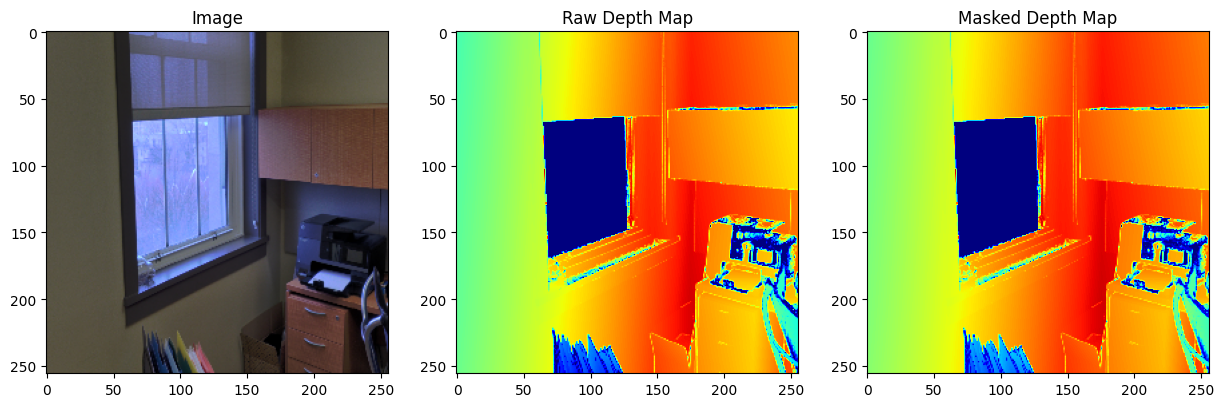

Min/Max depth before preprocessing: -1.1842825 180.33147
Min/Max depth after preprocessing: 0.1 1.3879536


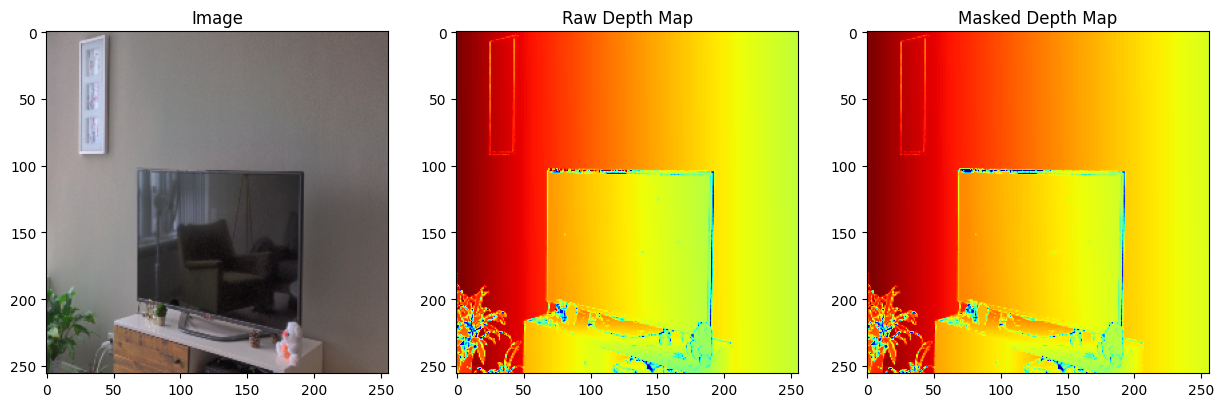

Min/Max depth before preprocessing: -1.1983333 182.98947
Min/Max depth after preprocessing: 0.1 0.96188265


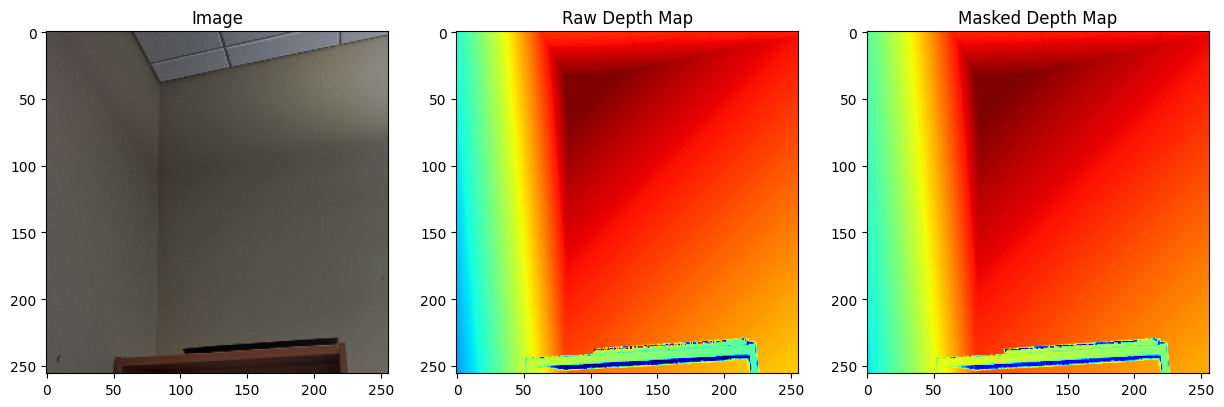

In [5]:
import matplotlib.pyplot as plt
def visualize_data(image, depth_map, mask):
    """
    Visualizes the image and its corresponding depth map with mask applied.
    """
    # Apply mask to depth map
    masked_depth = depth_map * mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    
    # Use plt.cm.jet colormap
    axes[1].imshow(depth_map, cmap=plt.cm.jet)  
    axes[1].set_title('Raw Depth Map')
    
    # Use plt.cm.jet colormap
    axes[2].imshow(masked_depth, cmap=plt.cm.jet) 
    axes[2].set_title('Masked Depth Map')
    plt.savefig("visualization_example.jpg")
    plt.show()
# Example usage 
for i in range(3):
    img, depth_map = load_and_preprocess_data(df.iloc[i]) 
    # Load the mask
    mask_path = df.iloc[i]['mask']
    mask = np.load(mask_path)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))  # Resize mask to match image
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    visualize_data(img, depth_map, mask)

In [6]:
def create_depth_estimation_model(input_shape=(256, 256, 3)):
    """
    Creates a depth estimation model with ResNet50 encoder and U-Net decoder.
    """
    # Encoder 
    inputs = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    # Get feature maps from encoder
    skip_connections = [
        base_model.get_layer("conv1_relu").output,        # (None, 128, 128, 64)
        base_model.get_layer("conv2_block3_out").output,  # (None, 64, 64, 256)
        base_model.get_layer("conv3_block4_out").output,  # (None, 32, 32, 512)
        base_model.get_layer("conv4_block6_out").output,  # (None, 16, 16, 1024)
    ]
    # Decoder
    up1 = UpSampling2D(size=(2, 2))(base_model.output)   # (None, 32, 32, 2048)
    concat1 = concatenate([up1, skip_connections[3]], axis=-1)  # (None, 32, 32, 3072)
    conv1 = Conv2D(1024, 3, activation='relu', padding='same')(concat1)
    conv1 = Conv2D(1024, 3, activation='relu', padding='same')(conv1)
    up2 = UpSampling2D(size=(2, 2))(conv1)   # (None, 64, 64, 1024)
    concat2 = concatenate([up2, skip_connections[2]], axis=-1)  # (None, 64, 64, 1536)
    conv2 = Conv2D(512, 3, activation='relu', padding='same')(concat2)
    conv2 = Conv2D(512, 3, activation='relu', padding='same')(conv2)
    up3 = UpSampling2D(size=(2, 2))(conv2)   # (None, 128, 128, 512)
    concat3 = concatenate([up3, skip_connections[1]], axis=-1)  # (None, 128, 128, 768)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(concat3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up4 = UpSampling2D(size=(2, 2))(conv3)   # (None, 256, 256, 256)
    concat4 = concatenate([up4, skip_connections[0]], axis=-1)  # (None, 256, 256, 320)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up5 = UpSampling2D(size=(2, 2))(conv4)   # (None, 512, 512, 128)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5) 
    # Output layer
    output = Conv2D(1, 1, activation='linear')(conv5)  # or 'sigmoid'
    model = Model(inputs=inputs, outputs=output)
    return model

In [7]:
from tensorflow.keras import backend as K
# def custom_loss(y_true, y_pred):
#     mse_loss = K.mean(K.square(y_true - y_pred))
#     huber_loss = tf.keras.losses.huber(y_true, y_pred)
    
#     # Combine the losses
#     total_loss = mse_loss + 0.1 * huber_loss  
#     return total_loss
def triplet_margin_loss(y_true, y_pred, margin=0.1):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = K.sum(K.square(anchor - positive), axis=-1)
    neg_dist = K.sum(K.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + margin
    loss = K.maximum(basic_loss, 0.0)
    return K.mean(loss)

In [8]:
from sklearn.model_selection import train_test_split
images = []
depth_maps = []
for index, row in df.iterrows():
    img, depth_map = load_and_preprocess_data(row)
    images.append(img)
    depth_maps.append(depth_map)
images = np.array(images)
depth_maps = np.array(depth_maps)
X_train, X_val, y_train, y_val = train_test_split(
    images, depth_maps, test_size=0.2, random_state=42
)

Min/Max depth before preprocessing: -1.2021767 200.93497
Min/Max depth after preprocessing: 0.1 1.4848069
Min/Max depth before preprocessing: -1.1842825 180.33147
Min/Max depth after preprocessing: 0.1 1.3879536
Min/Max depth before preprocessing: -1.1983333 182.98947
Min/Max depth after preprocessing: 0.1 0.96188265
Min/Max depth before preprocessing: 0.0 154.1777
Min/Max depth after preprocessing: 0.1 2.12083
Min/Max depth before preprocessing: -1.2037597 172.92522
Min/Max depth after preprocessing: 0.1 1.7626345
Min/Max depth before preprocessing: -0.47693574 164.48697
Min/Max depth after preprocessing: 0.1 1.888351
Min/Max depth before preprocessing: -0.27772647 76.01367
Min/Max depth after preprocessing: 0.1 0.953218
Min/Max depth before preprocessing: -1.1955576 142.41672
Min/Max depth after preprocessing: 0.1 1.7073662
Min/Max depth before preprocessing: -1.1890867 152.70172
Min/Max depth after preprocessing: 0.1 1.704181
Min/Max depth before preprocessing: -1.2032349 219.49905


In [9]:
def recall_at_k(y_true, y_pred, k=5):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    _, indices = tf.math.top_k(y_pred, k=k)
    recall = tf.reduce_mean(tf.cast(tf.gather(y_true, indices) > 0, tf.float32))
    return recall

In [10]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import UpSampling2D, concatenate, Conv2D
from tensorflow.keras.models import Model

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-3)

with tf.device('/GPU:0'):
    model = create_depth_estimation_model()
    model.compile(optimizer=optimizer, loss=triplet_margin_loss, metrics=[recall_at_k])
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=4,
        validation_data=(X_val, y_val),
        shuffle=True
    )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 172s 541ms/step - loss: 0.1071 - recall_at_k: 1.0000 - val_loss: 0.1000 - val_recall_at_k: 1.0000
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 51s 333ms/step - loss: 0.0964 - recall_at_k: 1.0000 - val_loss: 0.1002 - val_recall_at_k: 1.0000
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - loss: 0.0901 - recall_at_k: 1.0000 - val_loss: 0.1060 - val_recall_at_k: 1.0000
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - loss: 0.0818 - recall_at_k: 1.0000 - val_loss: 0.1308 - val_recall_at_k: 1.0000
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - loss: 0.0685 - recall_at_k: 1.0000 - val_loss: 0.1092 - val_recall_at_k: 1.0000
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 326ms/step - loss: 0.0509 - recall_at_k: 1.0000 - val_loss: 0.1512 - val_recall_at_k: 1.0000
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 325ms/step - loss: 0.0427 - recall_at_k: 1.0000 - val_loss: 0.1862 - val_recall_at

In [11]:
import cv2
import tensorflow as tf

def load_and_preprocess_image(image_path, img_size=(256, 256)):
    """Loads and preprocesses a single image."""
    img = cv2.imread(image_path)
    
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

new_image = load_and_preprocess_image("/kaggle/input/6yhtb6/00024_00201_outdoor_070_030.png")


In [12]:
import numpy as np

new_image = np.array(new_image)  # Convert to NumPy array
predicted_depth = model.predict(np.expand_dims(new_image, axis=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


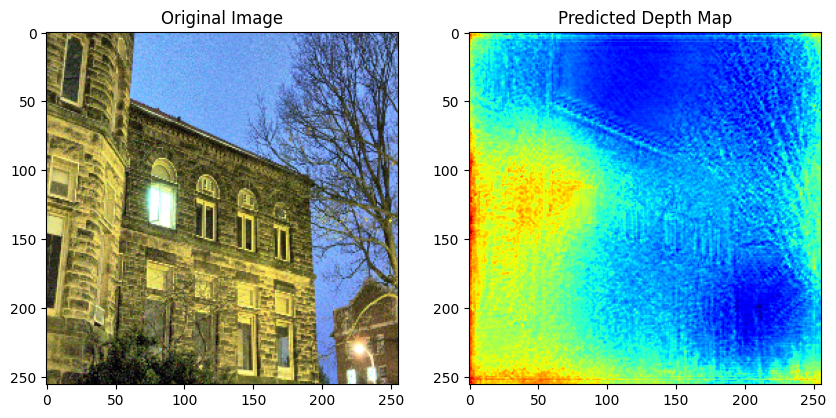

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(new_image)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(predicted_depth[0, :, :, 0], cmap=plt.cm.jet) 
plt.title("Predicted Depth Map")
plt.show()

In [ ]:
# New Cell: Implementing Channel Attention Mechanism
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape

def channel_attention(input_feature, ratio=8):
    """Applies channel attention mechanism to input feature map."""
    channel = input_feature.shape[-1]
    
    # Global Average Pooling
    shared_layer_one = GlobalAveragePooling2D()(input_feature)
    shared_layer_one = Reshape((1, 1, channel))(shared_layer_one)
    
    # Fully Connected Layers
    shared_layer_two = Dense(channel // ratio, activation='relu', use_bias=False)(shared_layer_one)
    shared_layer_three = Dense(channel, activation='sigmoid', use_bias=False)(shared_layer_two)
    
    # Apply attention
    attention_output = Multiply()([input_feature, shared_layer_three])
    return attention_output

# Modify the Model to Include Channel Attention

def create_depth_estimation_model_with_attention(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    
    skip_connections = [
        base_model.get_layer("conv1_relu").output,
        base_model.get_layer("conv2_block3_out").output,
        base_model.get_layer("conv3_block4_out").output,
        base_model.get_layer("conv4_block6_out").output,
    ]
    
    # Apply channel attention to encoder outputs
    skip_connections = [channel_attention(skip) for skip in skip_connections]
    
    up1 = UpSampling2D(size=(2, 2))(base_model.output)
    concat1 = concatenate([up1, skip_connections[3]], axis=-1)
    conv1 = Conv2D(1024, 3, activation='relu', padding='same')(concat1)
    conv1 = Conv2D(1024, 3, activation='relu', padding='same')(conv1)
    
    up2 = UpSampling2D(size=(2, 2))(conv1)
    concat2 = concatenate([up2, skip_connections[2]], axis=-1)
    conv2 = Conv2D(512, 3, activation='relu', padding='same')(concat2)
    conv2 = Conv2D(512, 3, activation='relu', padding='same')(conv2)
    
    up3 = UpSampling2D(size=(2, 2))(conv2)
    concat3 = concatenate([up3, skip_connections[1]], axis=-1)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(concat3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    up4 = UpSampling2D(size=(2, 2))(conv3)
    concat4 = concatenate([up4, skip_connections[0]], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    output = Conv2D(1, 1, activation='linear')(conv5)
    model = Model(inputs=inputs, outputs=output)
    
    return model

# Training with Attention Model
with tf.device('/GPU:0'):
    model_with_attention = create_depth_estimation_model_with_attention()
    model_with_attention.compile(optimizer=optimizer, loss=triplet_margin_loss, metrics=[recall_at_k])
    history_with_attention = model_with_attention.fit(
        X_train, y_train, epochs=20, batch_size=4, validation_data=(X_val, y_val), shuffle=True
    )

# Final Cell: Error Comparison
import matplotlib.pyplot as plt
import numpy as np

def compare_errors(original_model, attention_model, test_images, test_depth_maps):
    """Compares errors between the original and attention-based models."""
    original_preds = original_model.predict(test_images)
    attention_preds = attention_model.predict(test_images)
    
    original_mae = np.mean(np.abs(original_preds - test_depth_maps))
    attention_mae = np.mean(np.abs(attention_preds - test_depth_maps))
    
    print(f"Original Model MAE: {original_mae:.4f}")
    print(f"Attention Model MAE: {attention_mae:.4f}")
    
    for i in range(5):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[i])
        plt.title("Original Image")
        
        plt.subplot(1, 3, 2)
        plt.imshow(original_preds[i, :, :, 0], cmap=plt.cm.jet)
        plt.title("Original Model Depth")
        
        plt.subplot(1, 3, 3)
        plt.imshow(attention_preds[i, :, :, 0], cmap=plt.cm.jet)
        plt.title("Attention Model Depth")
        plt.show()

# Running comparison
compare_errors(model, model_with_attention, X_val[:5], y_val[:5])